Consider problem
$$
f''(x) -\frac{2}{x}f'(x) + \frac{2}{x^2}f(x) - x^6 = 0 \\
f(1) = 1 \\
f(2) = 2
$$
on $x \in [1,2]$. Analytic solution is
$$
f(x) = \frac{1}{42}x(168 - 127x + x^7)
$$

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import torch.nn as nn
import solver2 as solver

In [8]:
def differential(x, f):
    # f''(x) - 2/x f'(x) + 2/x^2 f(x) - x^6 = 0
    x = x.requires_grad_(True)
    fx = f(x)
    Dfx = autograd.grad(fx, x, grad_outputs=torch.ones_like(fx), create_graph=True)[0]
    D2fx = autograd.grad(Dfx, x, grad_outputs=torch.ones_like(Dfx), create_graph=True)[0]
    return D2fx - (2/x)*Dfx + (2/x**2)*fx - x**6

# Check the dimensions

def bc1(xb, f):
    # f(xb) = 1, xb = 1
    fxb = f(xb)
    return fxb - 1.0

def bc2(xb, f):
    # f(xb) = 2, xb = 2
    fxb = f(xb)
    return fxb - 2.0

xmin, xmax = 1.0, 2.0
num_points = 100
domain = torch.linspace(xmin, xmax, num_points).reshape(-1, 1)
domain = domain[1:-1] # Remove boundary points from domain

xb1 = torch.tensor([1.0]).reshape(-1, 1)
xb2 = torch.tensor([2.0]).reshape(-1, 1)
bc_tuples = [(bc1, xb1), (bc2, xb2)]

loss_fn = solver.LossFunction(differential, bc_tuples)

In [12]:
model = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 1)
)

epochs = 50000
lr = 0.0002

loss_data = solver.train(model, loss_fn, domain, epochs, lr, print_progress=True, print_progress_percentage=0.1)

Epoch 5000/50000 (10.0%) Loss: 92.59263610839844
Epoch 10000/50000 (20.0%) Loss: 6.5421295166015625
Epoch 15000/50000 (30.0%) Loss: 0.017461592331528664
Epoch 20000/50000 (40.0%) Loss: 0.0019636754877865314
Epoch 25000/50000 (50.0%) Loss: 0.00041383583447895944
Epoch 30000/50000 (60.0%) Loss: 0.00018078320135828108
Epoch 35000/50000 (70.0%) Loss: 0.00012227665865793824
Epoch 40000/50000 (80.0%) Loss: 9.447179036214948e-05
Epoch 45000/50000 (90.0%) Loss: 0.00010784415644593537
Epoch 50000/50000 (100.0%) Loss: 5.932891872362234e-05


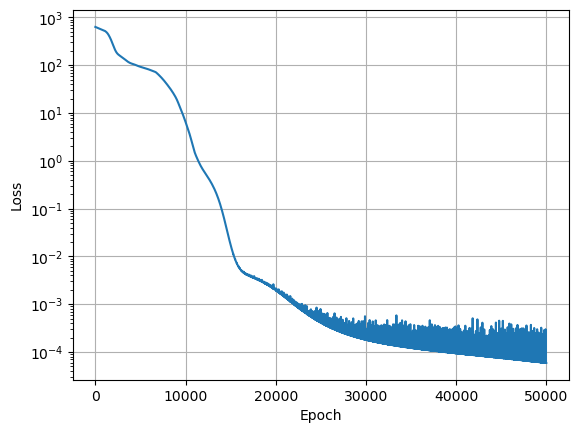

In [15]:
plt.plot(loss_data)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid()
plt.savefig('ode_loss.png')
plt.show()

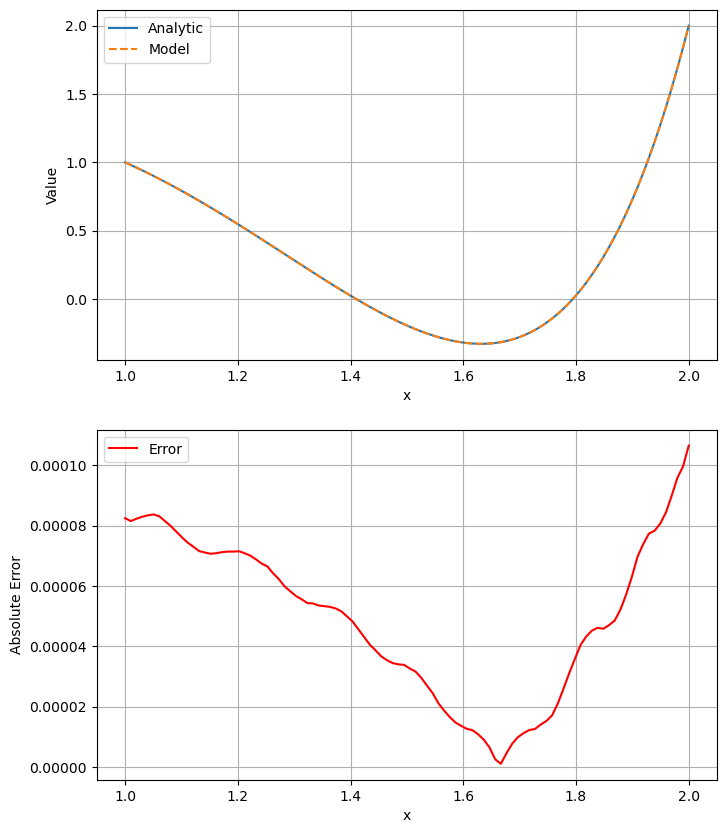

In [16]:
def analytic(x):
    # f(x) = x(168 - 127x + x^7)/42
    return (1/42)*x*(168 - 127*x + x**7)

x_eval = torch.linspace(xmin, xmax, 100).reshape(-1, 1)
model.eval()
with torch.no_grad():
    y_pred = model(x_eval)
y_true = analytic(x_eval)

x_eval.numpy()
y_pred.numpy()
y_true.numpy()

error = np.abs(y_pred - y_true)

fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].plot(x_eval.numpy(), y_true.numpy(), label='Analytic')
ax[0].plot(x_eval.numpy(), y_pred.numpy(), label='Model', linestyle='--')
ax[0].set_xlabel('x')
ax[0].set_ylabel('Value')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(x_eval, error, label='Error', color='red')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Absolute Error')
ax[1].grid(True)
ax[1].legend()

plt.savefig('ode-sol.png')
plt.show()